In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

os.makedirs("Image", exist_ok=True)


In [2]:
df = pd.read_csv("Apple_clean.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').set_index('Date')

series = df['Close'].asfreq('D').ffill()

print(f"Date range: {series.index.min().date()} → {series.index.max().date()}")
print(f"Total records: {len(series)}")


Date range: 2009-12-31 → 2025-10-29
Total records: 5782


In [3]:
n = len(series)
train_size = int(n * 0.6)
val_size = int(n * 0.2)
test_size = n - train_size - val_size

train = series.iloc[:train_size]
val = series.iloc[train_size: train_size + val_size]
test = series.iloc[train_size + val_size:]

print("Train:", len(train), "Validate:", len(val), "Test:", len(test))


Train: 3469 Validate: 1156 Test: 1157


In [4]:
# Mô hình ETS có seasonal = 'add', seasonal_periods = 7
model_train = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=7,
    initialization_method='estimated'
)
fit_train = model_train.fit(optimized=True)
pred_val = fit_train.forecast(len(val))
pred_val.index = val.index


In [5]:
mape_val = mean_absolute_percentage_error(val, pred_val)
rmse_val = np.sqrt(mean_squared_error(val, pred_val))
print(f"Validate MAPE: {mape_val:.3%}")
print(f"Validate RMSE: {rmse_val:.4f}")


Validate MAPE: 45.768%
Validate RMSE: 70.0007


In [6]:
train_val = pd.concat([train, val])

model_trainval = ExponentialSmoothing(
    train_val,
    trend='add',
    seasonal='add',
    seasonal_periods=7,
    initialization_method='estimated'
)
fit_trainval = model_trainval.fit(optimized=True)

pred_test = fit_trainval.forecast(len(test))
pred_test.index = test.index

# Dự báo 30 ngày tới
future_steps = 30
future_forecast = fit_trainval.forecast(future_steps)
index_next_30_days = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')
future_forecast.index = index_next_30_days


In [7]:
mape_test = mean_absolute_percentage_error(test, pred_test)
rmse_test = np.sqrt(mean_squared_error(test, pred_test))
print(f"Test MAPE: {mape_test:.3%}")
print(f"Test RMSE: {rmse_test:.4f}")


Test MAPE: 10.612%
Test RMSE: 27.3807


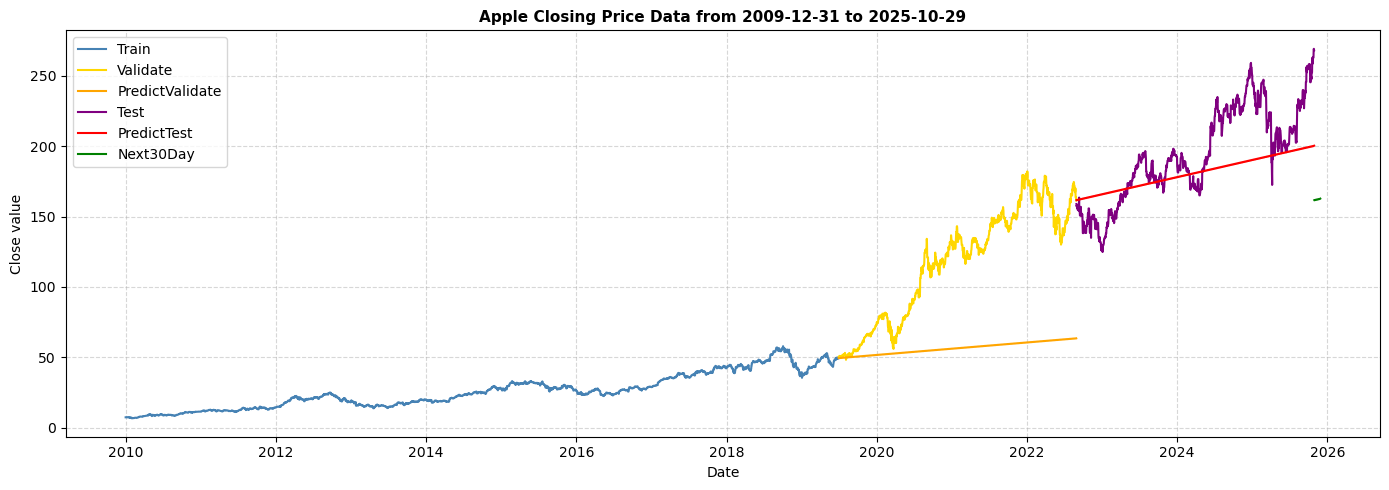

In [8]:
plt.figure(figsize=(14,5))

plt.plot(train.index, train, label='Train', color='steelblue')
plt.plot(val.index, val, label='Validate', color='gold')
plt.plot(pred_val.index, pred_val, label='PredictValidate', color='orange')
plt.plot(test.index, test, label='Test', color='purple')
plt.plot(pred_test.index, pred_test, label='PredictTest', color='red')
plt.plot(index_next_30_days, future_forecast, label='Next30Day', color='green')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.title(f"Apple Closing Price Data from {series.index[0].strftime('%Y-%m-%d')} to {series.index[-1].strftime('%Y-%m-%d')}", fontsize=11, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Close value")
plt.tight_layout()
plt.savefig("Image/Apple_ETS_622.png", dpi=150)
plt.show()


In [10]:
with open("Image/Apple_ETS_622_summary.txt", "w", encoding="utf-8") as f:
    f.write("Model: ETS (trend=add, seasonal=add, seasonal_periods=7)\n")
    f.write(f"Validate MAPE: {mape_val:.6f}\nValidate RMSE: {rmse_val:.6f}\n")
    f.write(f"Test MAPE: {mape_test:.6f}\nTest RMSE: {rmse_test:.6f}\n")

print("Saved results → Image/Apple_ETS_622_summary.txt")


Saved results → Image/Apple_ETS_622_summary.txt
